# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Цель исследования:**
<u>обучить модель классифицировать комментарии на позитивные и негативные со значением метрики качества *F1* не меньше 0.75.</u> 

В нашем распоряжении набор данных с разметкой о токсичности правок.
**Исследование пройдет в 4 основных этапа:**
1. Обзор данных
2. Подготовка
3. Обучение
4. Вывод

## Обзор данных

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

import nltk 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
nltk.download('stopwords') 

import sklearn 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.dummy import DummyClassifier

from pymystem3 import Mystem
from tqdm import tqdm
tqdm.pandas()

pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_275/2873408409.py:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
df = pd.read_csv('/datasets/toxic_comments.csv')

display(df.head(10))
display(df.info())
display(df.describe())

print('Количество дубликатов:', df.duplicated().sum())

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,9,alignment on this subject and which are contrary to those of DuLithgow,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


Количество дубликатов: 0


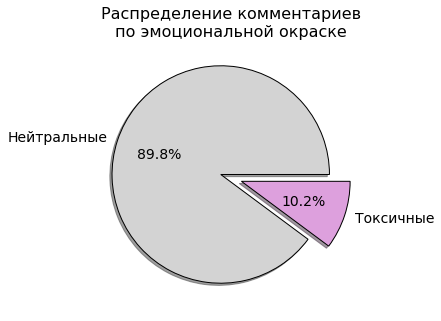

In [4]:
def distribution_pie(col):

    fig = plt.figure(figsize=(10,5))

    values = col.value_counts().tolist()
    labels = ['Нейтральные', 'Токсичные']     
    
    plt.pie(values, labels=labels, autopct='%1.1f%%', colors = ['lightgrey', 'plum'], 
               wedgeprops = {'lw':1, 'ls':'-','edgecolor':'black'},
               explode = [0.1, 0.1], shadow = True, textprops={'fontsize': 14})
    
    plt.title(f'Распределение комментариев\nпо эмоциональной окраске', fontsize = 16) 
    plt.show()
    
distribution_pie(df['toxic'])

### Вывод

В нашем распоряжении датафрейм с 159292 размеченными по тональности комментариями на английском языке. Около 10% от всех данных - негативно окрашенные, классы несбалансированы.

Столбец `text` содержит текст комментария, `toxic` — целевой признак (токсичный ли комментарий), `Unnamed: 0` - дублирует индексы, его нужно удалить.

Пропусков и дубликатов нет, можем утверждать, что данных достаточно для проведения исследования.  Приступим к их подготовке данных для обучения моделей.

## Подготовка

### Удаление столбца `Unnamed: 0`

In [5]:
df = df.drop('Unnamed: 0', axis = 1)
df.columns

Index(['text', 'toxic'], dtype='object')

### Очистка и лемматизация

In [6]:
wnl = WordNetLemmatizer()

def lemmatize_clear(text):
    clear = re.sub(r'[^a-zA-Z]', ' ', text).split()
    
    lemm = []
    
    for i in range(len(clear)):
        lemm.append(wnl.lemmatize(clear[i]))
        
    return " ".join(lemm)

In [7]:
corpus = df['text'].progress_apply(lemmatize_clear)
corpus[0]

100%|██████████| 159292/159292 [00:36<00:00, 4325.16it/s]


'Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalism just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now'

In [8]:
pd.DataFrame(corpus.str.len()).describe()

,text
count,159292.000000
mean,367.686720
std,553.888203
min,0.000000
25%,87.000000
50%,190.000000
75%,408.000000
max,5000.000000


### Разбиение на признаки и выборки

Доля features_train от lemm_df - 75 %
Доля target_train от lemm_df - 75 %


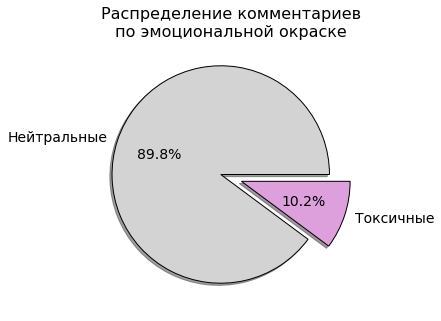

Доля features_test от lemm_df - 25 %
Доля target_test от lemm_df - 25 %


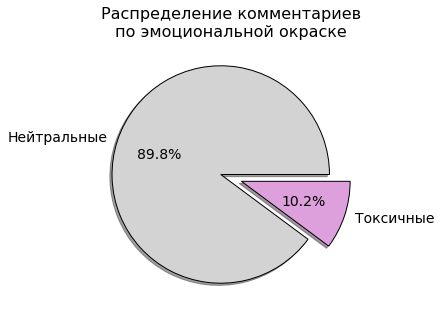

In [9]:
features = corpus
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42, stratify = target)

for selection, s_name in zip([features_train, target_train, features_test, target_test],
                             ['features_train', 'target_train', 'features_test', 'target_test']):
    
    
    print(f'Доля {s_name} от lemm_df -', int((selection.shape[0] / len(df))*100), '%')
    
    if 'target' in s_name:
        distribution_pie(selection)
        


### Векторизация обучающих признаков

In [10]:
stop_words = set(stopwords.words('english')) 
count_vect = CountVectorizer(stop_words=stop_words)
features_train = count_vect.fit_transform(features_train)

features_train[0].todense()

matrix([[0, 0, 0, ..., 0, 0, 0]])

In [11]:
features_test = count_vect.transform(features_test)

features_test[0].todense()

matrix([[0, 0, 0, ..., 0, 0, 0]])

### Вывод

Мы:

1. Избавились от столбца `Unnamed: 0`, дублирующего индексы.
2. Очистили, лемматизировали данные и представили векторизиривали.
3. Разбили данные на выборки (train и test в соотношении 3:1) и признаки, сохранив баланс классов. Features - полученная матрица c размерностью 159292 на 163969, хранит в себе 163969 уникальных слов.

Мы готовы обучать модели.

## Обучение

### Logistic Regression

In [12]:
%%time

lr = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000, C=3.5,
                        class_weight='balanced', verbose=1)
lr.fit(features_train, target_train)

[LibLinear]iter  1 act 9.963e+04 pre 8.243e+04 delta 1.472e+01 f 2.898e+05 |g| 1.302e+05 CG  88
cg reaches trust region boundary
iter  2 act 4.827e+04 pre 3.686e+04 delta 2.137e+01 f 1.902e+05 |g| 4.808e+04 CG  78
cg reaches trust region boundary
iter  3 act 3.917e+04 pre 3.088e+04 delta 2.922e+01 f 1.419e+05 |g| 2.562e+04 CG  76
cg reaches trust region boundary
iter  4 act 2.209e+04 pre 2.806e+04 delta 2.922e+01 f 1.028e+05 |g| 1.635e+04 CG  78
cg reaches trust region boundary
iter  5 act -1.259e+04 pre 8.721e+04 delta 1.361e+01 f 8.068e+04 |g| 2.507e+04 CG  25
cg reaches trust region boundary
iter  5 act -6.481e+03 pre 4.757e+04 delta 6.371e+00 f 8.068e+04 |g| 2.507e+04 CG  15
cg reaches trust region boundary
iter  5 act 3.646e+03 pre 2.588e+04 delta 3.185e+00 f 8.068e+04 |g| 2.507e+04 CG  10
cg reaches trust region boundary
iter  6 act 4.883e+03 pre 4.501e+04 delta 1.593e+00 f 7.703e+04 |g| 2.889e+04 CG   4
cg reaches trust region boundary
iter  7 act 4.082e+03 pre 1.836e+04 delta 7

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LogisticRegression(C=3.5, class_weight='balanced', max_iter=1000,
                   random_state=12345, solver='liblinear', verbose=1)

In [13]:
predictions = lr.predict(features_test)
lr_f1 = f1_score(target_test, predictions)
print(f'F1: {lr_f1}')

F1: 0.7524775293846508


### DecisionTreeClassifier

In [14]:
%%time

dtc = DecisionTreeClassifier(random_state=12345, class_weight='balanced') 
dtc.fit(features_train, target_train)

CPU times: user 1min 38s, sys: 2.51 s, total: 1min 40s
Wall time: 1min 40s


DecisionTreeClassifier(class_weight='balanced', random_state=12345)

In [15]:
predictions = dtc.predict(features_test)
dtc_f1 = f1_score(target_test, predictions)
print(f'F1: {dtc_f1}')

F1: 0.6352481268324466


## Выводы

1. Мы изучили датафрейм с 159292 размеченными по тональности комментариями на английском языке. Около 10% от всех данных - негативно окрашенные, наблюдается сильный дисбалансов классов.


2. Подготовили данные к обучению моделей: 
    - избавились от столбца Unnamed: 0, дублирующего индексы;
    - очистили, лемматизировали данные и представили векторизиривали.
    - разбили данные на выборки (train и test в соотношении 3:1) и признаки, сохранив баланс классов. Features - полученная матрица c размерностью 159292 на 163969, хранит в себе 163969 уникальных слов.
    
    
3. Обучили Логистическую регрессию и дерево решений, взвесив классы. Лучшую  F1-меру дала регрессия, а именно 0.753.

**Таким образом, в качестве инструмента для выявления токсичных комментариев, рекомендуем интернет-магазину «Викишоп» модель lr с обратной силой регуляризации = 3.5, которая дала F1 на тестовой выборке = 0.753.**

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны